In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [5]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers, models

In [6]:
kaggle_cred = json.load(open("kaggle.json"))

In [7]:
os.environ['KAGGLE_USERNAME'] = kaggle_cred['username']
os.environ['KAGGLE_KEY'] = kaggle_cred['key']

In [8]:
#!/bin/bash
!kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.75G/1.76G [00:16<00:00, 137MB/s]
100% 1.76G/1.76G [00:16<00:00, 112MB/s]


In [9]:
with ZipFile("lung-and-colon-cancer-histopathological-images.zip", "r") as zip_ref:
  zip_ref.extractall()

In [10]:
import shutil

# Set your main dataset directory path
main_dir = '/content/lung_colon_image_set'

# List the subfolders you want to extract classes from
sub_dirs = ['colon_image_sets', 'lung_image_sets']

# Loop through each of the subfolders (colon, lung)
for sub in sub_dirs:
    sub_path = os.path.join(main_dir, sub)

    # Check if the subfolder exists
    if os.path.isdir(sub_path):
        for class_folder in os.listdir(sub_path):
            class_folder_path = os.path.join(sub_path, class_folder)

            # Check if it's a folder (not a file)
            if os.path.isdir(class_folder_path):
                new_location = os.path.join(main_dir, class_folder)

                # Move the class folder
                shutil.move(class_folder_path, new_location)
                print(f"Moved {class_folder} to {main_dir}")

        # After moving all class folders, remove the empty parent folder
        os.rmdir(sub_path)
        print(f"Deleted folder: {sub_path}")
    else:
        print(f"Folder not found: {sub_path}")


Moved colon_aca to /content/lung_colon_image_set
Moved colon_n to /content/lung_colon_image_set
Deleted folder: /content/lung_colon_image_set/colon_image_sets
Moved lung_scc to /content/lung_colon_image_set
Moved lung_n to /content/lung_colon_image_set
Moved lung_aca to /content/lung_colon_image_set
Deleted folder: /content/lung_colon_image_set/lung_image_sets


In [11]:
data = tf.keras.utils.image_dataset_from_directory("lung_colon_image_set")

Found 25000 files belonging to 5 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
batch[0].shape

(32, 256, 256, 3)

In [15]:
# Class 1 = colon_aca
# Class 1 = colon_n
# Class 1 = lung_aca
# Class 1 = lung_n
# Class 1 = lung_scc

batch[1]

array([3, 2, 4, 2, 2, 3, 2, 2, 0, 4, 2, 2, 4, 4, 0, 2, 1, 3, 4, 4, 3, 4,
       4, 1, 1, 1, 1, 2, 3, 1, 2, 3], dtype=int32)

In [ ]:
## Scale Data

In [16]:
scaled_data = data.map(lambda x, y: (x/255, y))

In [17]:
scaled_iterator = scaled_data.as_numpy_iterator().next()

## Split Data

In [18]:
len(scaled_data)

782

In [19]:
train_size = int(len(scaled_data)*0.6)+1
val_size = int(len(scaled_data)*0.2)
test_size = int(len(scaled_data)*0.2)

In [20]:
(train_size, val_size, test_size)

(470, 156, 156)

In [21]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

In [22]:
## Build the deep neural network

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
# Conv Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

# Conv Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Conv Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Conv Block 4
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # 5 output classes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,717 (25.98 MB)

 Trainable params: 6,811,717 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
## Train

In [29]:
history = model.fit(
    train,
    epochs=10,
    validation_data=val,
)

Epoch 1/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 136s 269ms/step - accuracy: 0.5500 - loss: 0.9341 - val_accuracy: 0.8239 - val_loss: 0.4129
Epoch 2/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 94s 201ms/step - accuracy: 0.7850 - loss: 0.4876 - val_accuracy: 0.8604 - val_loss: 0.3722
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 95s 201ms/step - accuracy: 0.8444 - loss: 0.3758 - val_accuracy: 0.8976 - val_loss: 0.2436
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 125s 265ms/step - accuracy: 0.8860 - loss: 0.2949 - val_accuracy: 0.9343 - val_loss: 0.1662
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 125s 265ms/step - accuracy: 0.9190 - loss: 0.2161 - val_accuracy: 0.9503 - val_loss: 0.1312
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 125s 229ms/step - accuracy: 0.9339 - loss: 0.1758 - val_accuracy: 0.9437 - val_loss: 0.1449
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 94s 199ms/step - accuracy: 0.9408 - loss: 0.1562 - val_accuracy: 0.9507 - val_loss: 0.1249
Epoch 8/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 124s 265ms/step - accuracy: 0.9499 - lo

In [30]:
history.history

{'accuracy': [0.6751329898834229,
  0.8040558695793152,
  0.8632978796958923,
  0.8938164710998535,
  0.9226064085960388,
  0.9367021322250366,
  0.9446143507957458,
  0.952659547328949,
  0.9577792286872864,
  0.9587101340293884],
 'loss': [0.6851234436035156,
  0.45433905720710754,
  0.3376834988594055,
  0.27509281039237976,
  0.20629504323005676,
  0.17027141153812408,
  0.14975665509700775,
  0.11968932300806046,
  0.11394300311803818,
  0.1044534295797348],
 'val_accuracy': [0.8239182829856873,
  0.8603765964508057,
  0.8976362347602844,
  0.9342948794364929,
  0.9503205418586731,
  0.9437099099159241,
  0.9507211446762085,
  0.9631410241127014,
  0.9431089758872986,
  0.9731570482254028],
 'val_loss': [0.41286933422088623,
  0.37215447425842285,
  0.24359504878520966,
  0.16618898510932922,
  0.1311902403831482,
  0.14490056037902832,
  0.12491574883460999,
  0.10996183007955551,
  0.15495498478412628,
  0.07557042688131332]}

In [31]:
## Plot perfromance

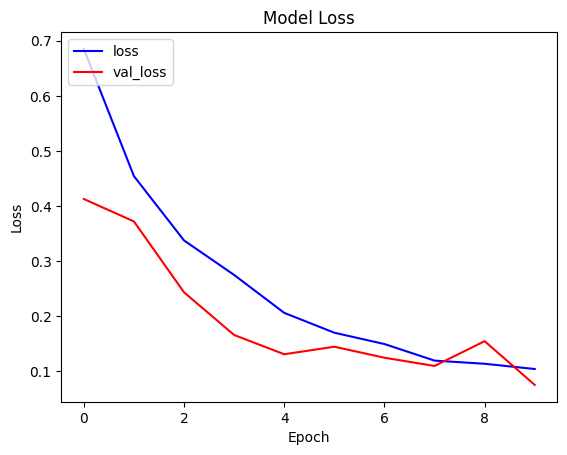

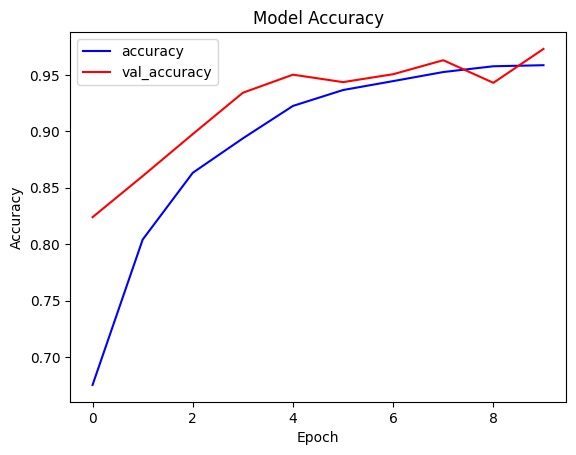

In [32]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [33]:
## Evaluating our model's performance

In [34]:
# Model Evaluation
print("Evaluation Results")
val_loss, val_accuracy = model.evaluate(val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Evaluation Results
156/156 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9745 - loss: 0.0689
Validation Accuracy: 97.18%


In [35]:
# Model Evaluation
print("Evaluation Results")
test_loss, test_accuracy = model.evaluate(test)
print(f'Test set Accuracy: {test_accuracy * 100:.2f}%')

Evaluation Results
156/156 ━━━━━━━━━━━━━━━━━━━━ 64s 93ms/step - accuracy: 0.9715 - loss: 0.0819
Test set Accuracy: 96.94%


In [36]:
## Test the data on an unseen image

In [37]:
class_names = data.class_names

class_indices = {i: name for i, name in enumerate(class_names)}

In [38]:
# Function to load and preprocess the image using Pillow
def load_and_preprocess_image(image_path, target_size=(256,256)):
  # Loan the image
  img = Image.open(image_path)
  #Resize the image
  img = img.resize(target_size)
  # Convert the image to a numpy array
  img_array = np.array(img)
  # Add batch dimension
  img_array = np.expand_dims(img_array, axis=0)
  # Scale the image values to [0, 1]
  img_array = img_array.astype('float32')/ 255.
  return img_array

# Function to predict the class of an image
def predict_image_class(model, image_path, class_indices):
  preprocessed_image = load_and_preprocess_image(image_path)
  predictions = model.predict(preprocessed_image)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  predicted_class_name = class_indices[predicted_class_index]
  return predicted_class_name

In [39]:
json.dump(class_indices, open("class_indices.json", "w"))

In [40]:
# Example
image_path = '/content/lung_colon_image_set/lung_n/lungn1002.jpeg'

predicted_class = predict_image_class(model, image_path, class_indices)

print("Precited class for image:",predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
Precited class for image: lung_n


In [42]:
model.save('drive/MyDrive/model.keras')